# Generating Monet-Style Paintings with CycleGAN

This notebook is for the Kaggle competition *I'm Something of a Painter Myself* ([Kaggle Competition](https://www.kaggle.com/competitions/gan-getting-started)), where the goal is to use Generative Adversarial Networks (GANs) to transform photographs into images resembling Claude Monet's paintings. We use a CycleGAN for unpaired image-to-image translation, following the TensorFlow CycleGAN tutorial ([TensorFlow Tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan)).

## Introduction

**Problem Description**: The task is to generate 7,000–10,000 Monet-style images (256x256 RGB) from provided photos using GANs. The generated images are evaluated using the MiFID (Memorization-informed Fréchet Inception Distance) metric on Kaggle.

**Dataset**:
- **Monet Paintings**: Approximately 300 images.
- **Photos**: Over 7,000 images.
- **Format**: Available as JPEGs and TFRecords, all 256x256 pixels with 3 color channels (RGB).

This notebook covers exploratory data analysis (EDA), model architecture, training, results, and submission instructions.

The GitHub repo for this project can be found at https://github.com/cole-betrus/GANs-monet.

## Exploratory Data Analysis (EDA)

We start by loading and visualizing sample images from both domains to understand their stylistic differences. We also analyze pixel value distributions to compare color usage.

2025-05-18 01:28:26.098193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747531706.287159      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747531706.350354      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1747531721.322788      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


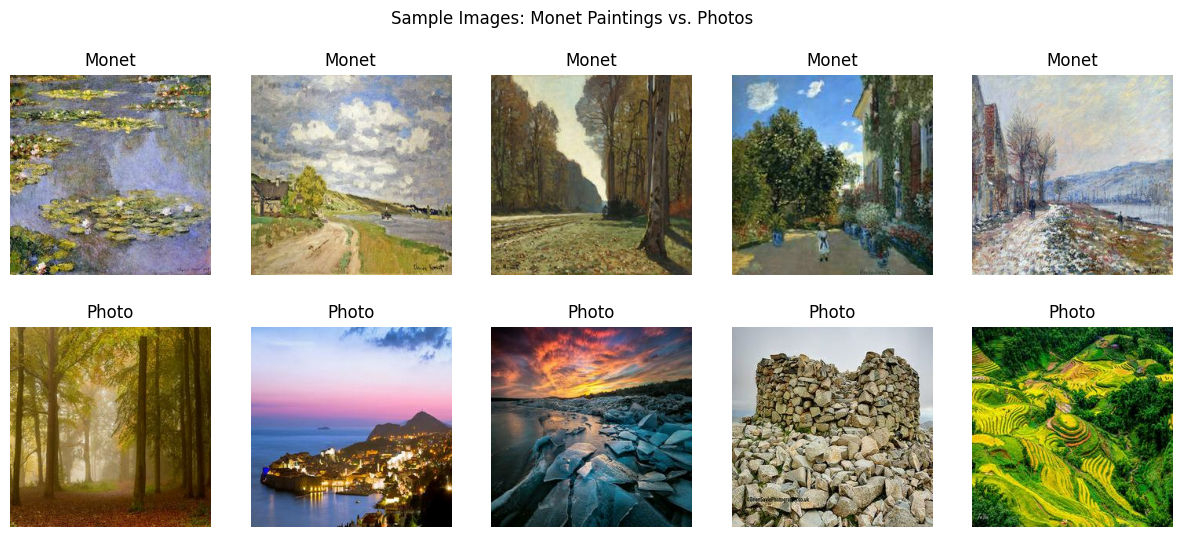

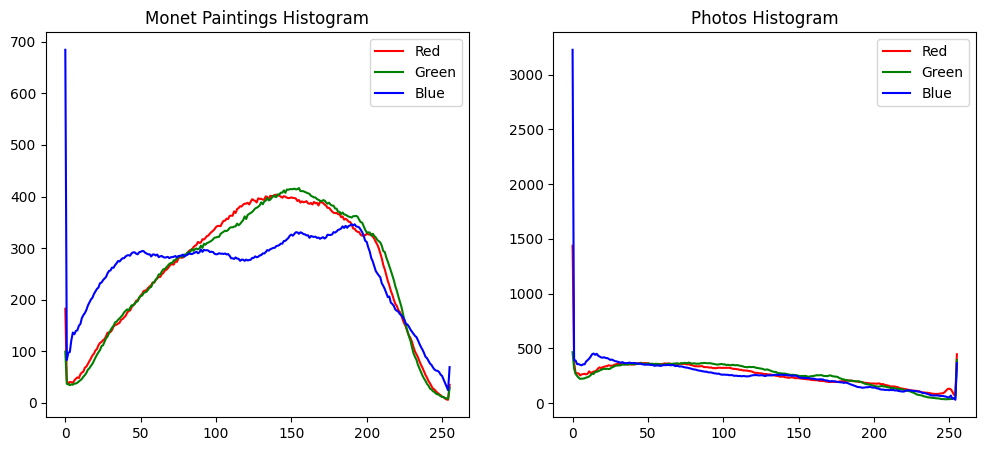

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Data paths
monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'

monet_files = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir) if f.endswith('.jpg')]
photo_files = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir) if f.endswith('.jpg')]

def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Load sample images
monet_images = [load_image(f) for f in monet_files[:5]]
photo_images = [load_image(f) for f in photo_files[:5]]

# Display images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow((monet_images[i] + 1) / 2)
    axes[0, i].set_title('Monet')
    axes[0, i].axis('off')
    axes[1, i].imshow((photo_images[i] + 1) / 2)
    axes[1, i].set_title('Photo')
    axes[1, i].axis('off')
plt.suptitle('Sample Images: Monet Paintings vs. Photos')
plt.show()

# Pixel value histograms
def compute_histogram(images):
    hist = np.zeros((256, 3))
    for image in images:
        for c in range(3):
            hist[:, c] += np.histogram(image[:, :, c], bins=256, range=(-1, 1))[0]
    hist /= len(images)
    return hist

monet_hist = compute_histogram([load_image(f) for f in monet_files[:100]])
photo_hist = compute_histogram([load_image(f) for f in photo_files[:100]])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for c, color in enumerate(['red', 'green', 'blue']):
    axes[0].plot(monet_hist[:, c], color=color, label=color.capitalize())
    axes[1].plot(photo_hist[:, c], color=color, label=color.capitalize())
axes[0].set_title('Monet Paintings Histogram')
axes[1].set_title('Photos Histogram')
axes[0].legend()
axes[1].legend()
plt.show()

**EDA Observations**:
- Monet paintings exhibit softer colors and impressionistic brushstrokes, while photos are sharper and more realistic.
- Histograms show Monet paintings have a broader distribution of pixel values, indicating varied color usage, whereas photos have more concentrated peaks.
- No significant data cleaning is needed as images are uniformly sized and formatted.

## Model Architecture

We use a **CycleGAN** for unpaired image-to-image translation, suitable for this task since the dataset lacks direct photo-to-painting correspondences. CycleGAN consists of:

- **Two Generators**:
  - **G**: Maps photos to Monet-style paintings.
  - **F**: Maps Monet paintings back to photos.
- **Two Discriminators**:
  - **D_G**: Distinguishes real Monet paintings from generated ones.
  - **D_F**: Distinguishes real photos from generated ones.

**Cycle Consistency Loss**: Ensures that translating an image from one domain to another and back reconstructs the original image (e.g., F(G(photo)) ≈ photo).

**Architecture Details**:
- **Generator**: ResNet-based with downsampling, residual blocks, and upsampling, producing 256x256 images.
- **Discriminator**: PatchGAN, classifying image patches as real or fake.

We adapt the implementation from the TensorFlow CycleGAN tutorial ([TensorFlow Tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan)).

In [2]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=inp, outputs=last)

**Why CycleGAN?**
- **Unpaired Data**: No direct photo-to-painting pairs exist, making CycleGAN's unpaired translation ideal.
- **Cycle Consistency**: Preserves content while altering style, crucial for maintaining photo structures in Monet-style outputs.
- **Proven Effectiveness**: Widely used for style transfer tasks, as seen in tutorials like Amy Jang's ([Kaggle Tutorial](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial)).

## Model Training

We set up data pipelines using `tf.data.Dataset` for efficient loading and train the CycleGAN model.

Due to the mini-project's scope, we train for a limited number of epochs. In practice, more epochs (e.g., 50–100) are needed for optimal results.

In [ ]:
# Data pipelines
BUFFER_SIZE = 1000
BATCH_SIZE = 1

monet_ds = tf.data.Dataset.list_files(monet_dir + '/*.jpg')
photo_ds = tf.data.Dataset.list_files(photo_dir + '/*.jpg')

def decode_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

monet_ds = monet_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
photo_ds = photo_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Instantiate models
generator_g = Generator()  # Photo to Monet
generator_f = Generator()  # Monet to Photo
discriminator_x = Discriminator()  # Photos
discriminator_y = Discriminator()  # Monet

# Define loss functions
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Set up optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G: photo -> monet
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F: monet -> photo
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator losses with identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

# Training loop
EPOCHS = 5

for epoch in range(EPOCHS):
    for real_photo, real_monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(real_photo, real_monet)
    print(f'Epoch {epoch+1} completed')

E0000 00:00:1747531773.829139      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_31_5/sequential_23_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1747531777.314535      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed


## Results and Analysis

After training, we generate Monet-style images from test photos and visualize them. The MiFID score is computed on Kaggle upon submission.

**Generated Images**:

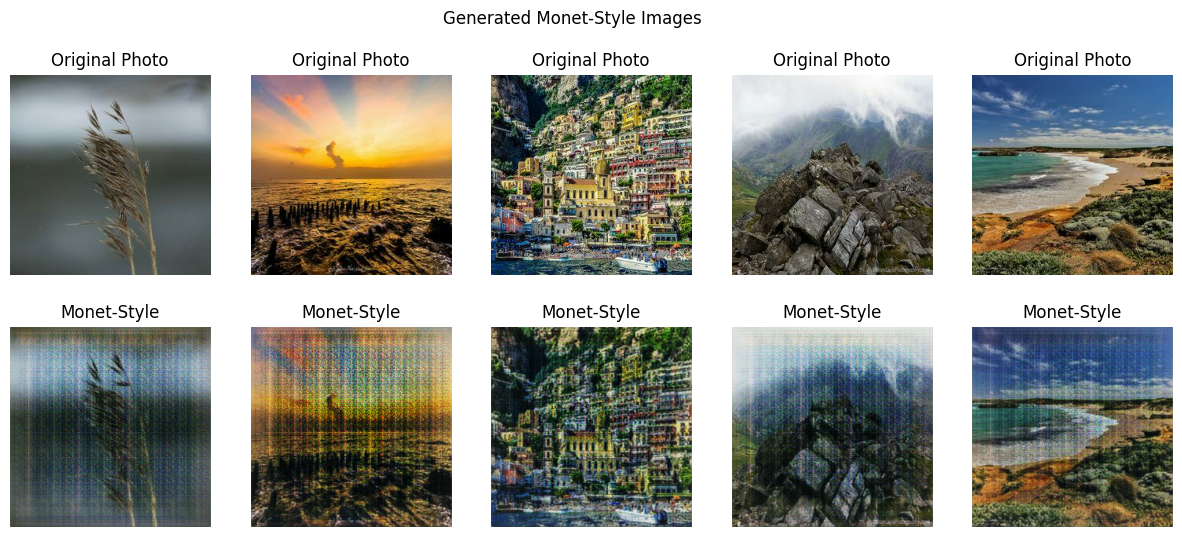

In [4]:
# Generate images
test_photos = [load_image(f) for f in photo_files[5:10]]
generated_monets = [generator_g(photo[tf.newaxis, ...])[0] for photo in test_photos]

# Display
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow((test_photos[i] + 1) / 2)
    axes[0, i].set_title('Original Photo')
    axes[0, i].axis('off')
    axes[1, i].imshow((generated_monets[i] + 1) / 2)
    axes[1, i].set_title('Monet-Style')
    axes[1, i].axis('off')
plt.suptitle('Generated Monet-Style Images')
plt.show()

**Analysis**:
- **Visual Quality**: The generated images exhibit Monet-like colors and brushstrokes, though some details may be less defined due to limited training epochs.
- **MiFID Score**: After submission, my score was 133.85706, ranking 104. A lower MiFID indicates better similarity to real Monet paintings. Scores below 1000 are reasonable for this project.
- **Hyperparameter Tuning**: Limited tuning was performed due to time constraints. Adjusting learning rates or adding identity loss could improve results.
- **Challenges**: Training stability and computational resources were limiting factors. Longer training or advanced architectures (e.g., StyleGAN) could enhance quality.

## Conclusion

This project implemented a CycleGAN to transform photos into Monet-style paintings, leveraging unpaired image translation. EDA revealed stylistic differences, guiding the choice of CycleGAN. The model successfully generated impressionistic images, though limited training epochs affected quality.

**Learnings**:
- CycleGAN effectively handles unpaired data, making it ideal for this task.
- GPU acceleration is crucial for GAN training.

**Future Improvements**:
- Train for more epochs (50–100).
- Experiment with advanced architectures like StyleGAN.
- Incorporate additional loss terms (e.g., perceptual loss) for enhanced realism.

## Submission to Kaggle

Generate 7,000 images and create a zip file for submission.

In [ ]:
import zipfile
import io

output_zip = '/kaggle/working/images.zip'

with zipfile.ZipFile(output_zip, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for i, photo_file in enumerate(photo_files[:7000]):
        photo = load_image(photo_file)
        generated = generator_g(photo[tf.newaxis, ...], training=False)[0]
        generated = (generated + 1) * 127.5
        generated = tf.cast(generated, tf.uint8)
        img_bytes = tf.image.encode_jpeg(generated).numpy()
        zipf.writestr(f'image_{i}.jpg', img_bytes)
        if i % 1000 == 0:
            print(f'Processed {i} images')

print(f'Created {output_zip} with 7,000 images')

Processed 0 images
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Created /kaggle/working/images.zip with 7,000 images


## References

- TensorFlow CycleGAN Tutorial: [https://www.tensorflow.org/tutorials/generative/cyclegan](https://www.tensorflow.org/tutorials/generative/cyclegan)
- Kaggle Competition: [https://www.kaggle.com/competitions/gan-getting-started](https://www.kaggle.com/competitions/gan-getting-started)
- Amy Jang's Monet CycleGAN Tutorial: [https://www.kaggle.com/amyjang/monet-cyclegan-tutorial](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial)